# AI Challenge 2020: Imager classification
## Data overview
* Author: Tobias Windisch (BhP/TEF-EAT3-IC)

In [1]:
import pandas as pd
import glob as glob
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import xgboost as xgb
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Resize jupyter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
df_labels = pd.read_csv('../mpc2_data/train_labels.csv')

In [3]:
df_labels.head()

,FilePath,ResultFinalCheck
0,MPC2_IM_L1/S42_P3/2018_09_07_06h/5b92a587_2144...,OK
1,MPC2_IM_L3/S42_42/2018_12_10_14h/5c0f25e2_3265...,OK
2,MPC2_IM_L2/S42_P4/2019_01_31_07h/5c52e0c1_3107...,OK
3,MPC2_IM_L2/S42_42/2019_01_31_17h/5c53cadf_3135...,OK
4,MPC2_IM_L2/S42_42/2018_11_06_08h/5be1e967_3033...,OK


<AxesSubplot:ylabel='ResultFinalCheck'>

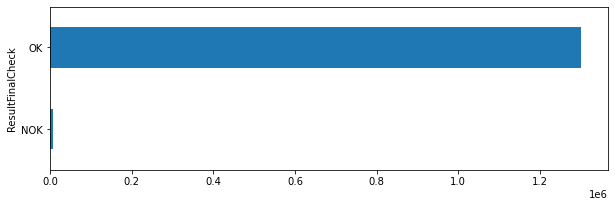

In [4]:
df_labels.groupby('ResultFinalCheck').size().plot(kind='barh', figsize=(10, 3))

### For demonstration purposes, restrict to one folder

In [8]:
#df_labels = df_labels[df_labels.FilePath.str.contains("MPC2_IM_L3/S42_42/2018_09_04_11h")]

## Parsing curves

In [5]:
def parse_curve(filepath):
    """
    Parses the curve into a pandas dataframe

    """
    df = pd.read_csv(
        filepath, 
        skiprows=33, 
        delimiter=';', 
        dtype=np.float,
        names=['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC'],
        usecols=range(7)
    )
    df.name = os.path.basename(filepath)
    df['frame'] = df.index
    df['energy'] = np.cumsum( (df.WegSpd1[1:].values - df.WegSpd1[:-1].values) * df.KraftSpd1[:-1])
    df['tag'] = df.name
    
    return df

In [237]:
df_curve = parse_curve('MPC2_IM_L3/S42_42/2018_09_04_11h/5b964bd2_9999_9999_IO.1')

In [238]:
df_curve.columns

Index(['WegSpd1', 'KraftSpd1', 'K7_1_TL', 'K7_2_TR', 'K7_3_BL', 'K7_4_BR',
       'K3m_MC', 'frame', 'energy', 'tag'],
      dtype='object')

In [271]:
df_curve

,WegSpd1,KraftSpd1,K7_1_TL,K7_2_TR,K7_3_BL,K7_4_BR,K3m_MC,frame,energy,tag
0,0.0000,19.6,0.226,0.311,0.287,0.433,0.604,0,-0.00980,5c5367b9_32541_54777_IO.1
1,-0.0005,19.4,0.214,0.323,0.299,0.433,0.604,1,-0.00980,5c5367b9_32541_54777_IO.1
2,-0.0005,19.4,0.226,0.311,0.299,0.433,0.604,2,-0.01950,5c5367b9_32541_54777_IO.1
3,-0.0010,19.2,0.214,0.311,0.287,0.433,0.604,3,-0.01950,5c5367b9_32541_54777_IO.1
4,-0.0010,19.1,0.214,0.311,0.287,0.433,0.604,4,-0.02905,5c5367b9_32541_54777_IO.1
...,...,...,...,...,...,...,...,...,...,...
2248,0.1760,0.0,41.425,33.209,42.035,23.676,33.722,2248,4.28305,5c5367b9_32541_54777_IO.1
2249,0.1760,0.0,41.425,33.221,42.035,23.676,33.734,2249,4.28305,5c5367b9_32541_54777_IO.1
2250,0.1760,0.0,41.425,33.209,42.023,23.676,33.734,2250,4.28305,5c5367b9_32541_54777_IO.1
2251,0.1760,0.0,41.266,33.197,42.181,23.676,33.624,2251,4.28305,5c5367b9_32541_54777_IO.1


In [288]:
gap_f = ['K7_1_TL', 'K7_2_TR', 'K7_3_BL', 'K7_4_BR','K3m_MC']
index_d005 = np.logical_and( df_curve['WegSpd1'] < 0.055, df_curve['WegSpd1'] > 0.045)
t1 = df_curve[gap_f][index_d005].mean().values
t2 = df_curve[gap_f].iloc[-1].values
np.r_[t1,t2,t1]

array([ 0.78394444,  1.40905556,  1.40577778,  2.16561111,  2.57916667,
       41.132     , 33.063     , 42.181     , 23.48      , 33.636     ,
        0.78394444,  1.40905556,  1.40577778,  2.16561111,  2.57916667])

In [12]:
def get_feature(df_curve):
    gap_f = ['K7_1_TL', 'K7_2_TR', 'K7_3_BL', 'K7_4_BR','K3m_MC']
    f1 = df_curve[gap_f].iloc[:10].mean().values
    
    w = 0.005
    index_d005 = np.logical_and( df_curve['WegSpd1'] < 0.05 + w, df_curve['WegSpd1'] > 0.05 - w)
    f2 = df_curve[gap_f][index_d005].mean().values
    
    index_d010 = np.logical_and( df_curve['WegSpd1'] < 0.10 + w, df_curve['WegSpd1'] > 0.10 - w)
    f3 = df_curve[gap_f][index_d010].mean().values
    
    index_d015 = np.logical_and( df_curve['WegSpd1'] < 0.15 + w, df_curve['WegSpd1'] > 0.15 - w)
    f4 = df_curve[gap_f][index_d015].mean().values
    
    feature_max = df_curve[gap_f].max().values
    
    feature_end = df_curve[gap_f].iloc[-1].values
    
    feature = np.r_[f1,f2,f3,f4,feature_max,feature_end]
    
    return feature

## Visualizing curves

In [7]:
def plot_curve(df_curve, ax=None):
        
    if not ax:
        _, ax = plt.subplots()
    
    for feature in ['K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC']:
#         df_curve[feature].plot(ax=ax, label=feature)
        ax.plot(df_curve['WegSpd1'], df_curve[feature], label=feature)
    
    ax.legend(loc='lower right')
    ax.set_title(df_curve.name)

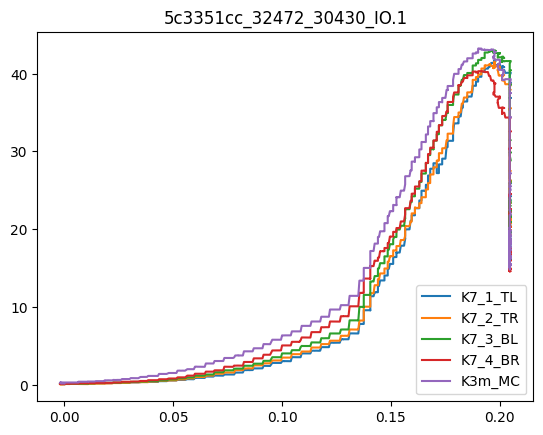

In [255]:
plot_curve(df_curve)

### Some OKs

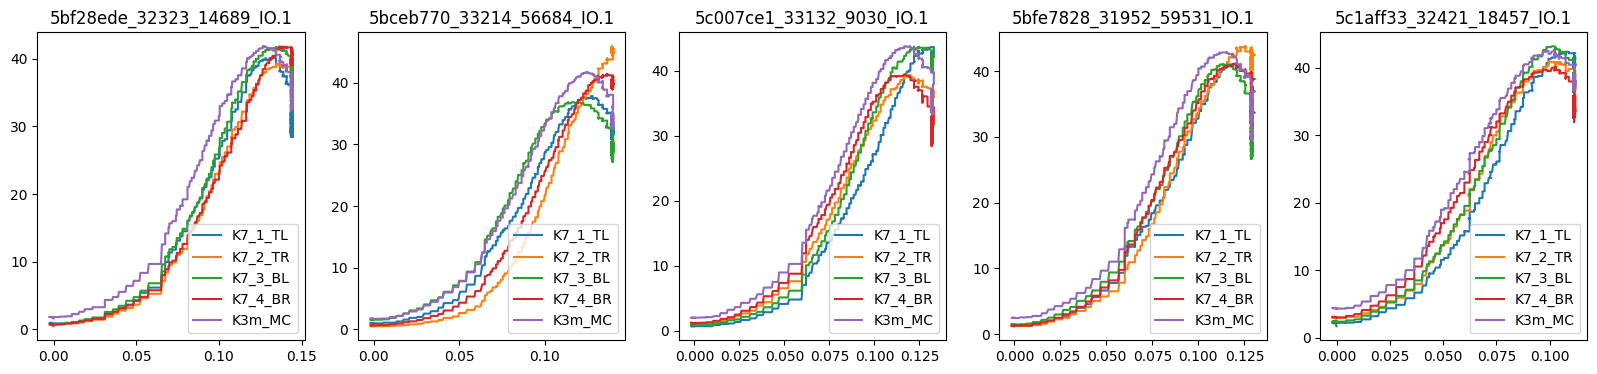

In [264]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(20, 4))
for ax, filepath in zip(axes.ravel(), df_labels[df_labels.ResultFinalCheck == 'OK'].FilePath.sample(5).values):
    
#     df_curve = parse_curve(os.path.join('/data_small/ai_challenge/', filepath))
    df_curve = parse_curve(filepath)
    plot_curve(df_curve, ax=ax)

### Some NOKs

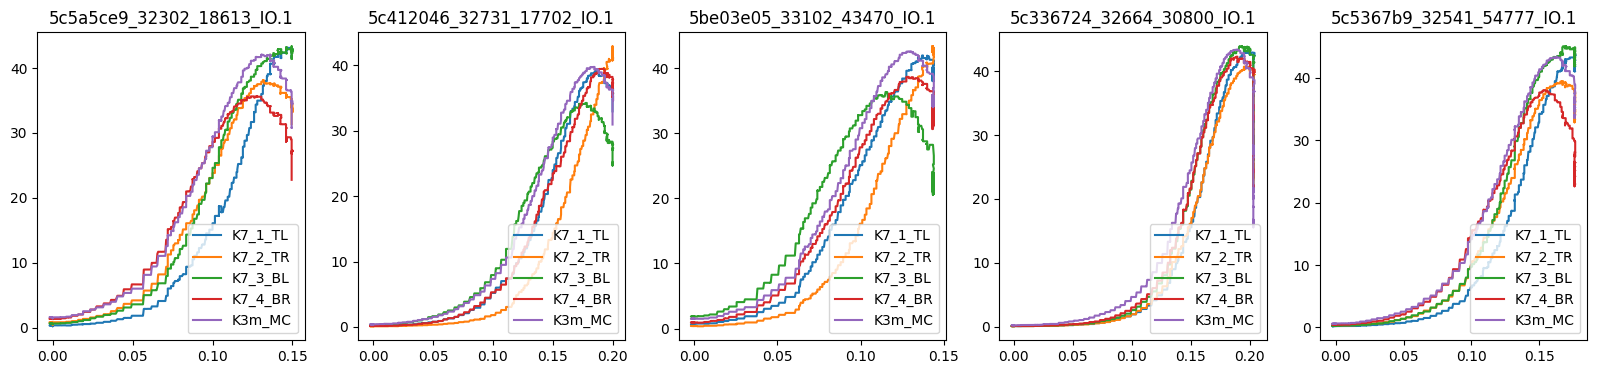

In [265]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(20, 4))
for ax, filepath in zip(axes.ravel(), df_labels[df_labels.ResultFinalCheck == 'NOK'].FilePath.sample(5).values):
    
    df_curve = parse_curve(filepath)
    plot_curve(df_curve, ax=ax)

# dive for feature


In [9]:
curve_path='/home/deeplearning/data_disk_2/mpc2_data/'

In [ ]:
ok_files = df_labels[df_labels.ResultFinalCheck == 'OK'].FilePath
nok_files = df_labels[df_labels.ResultFinalCheck == 'NOK'].FilePath

df_ok = pd.DataFrame(columns=['WegSpd1', 'KraftSpd1', 'K7_1_TL', 'K7_2_TR', 'K7_3_BL', 'K7_4_BR','K3m_MC'])
df_nok = pd.DataFrame(columns=['WegSpd1', 'KraftSpd1', 'K7_1_TL', 'K7_2_TR', 'K7_3_BL', 'K7_4_BR','K3m_MC'])

feature_ok, feature_nok = [], []
for f in ok_files.sample(1000).values:
    pf = parse_curve(os.path.join(curve_path, f))
    df_ok = df_ok.append(pf)
    
for f in nok_files.sample(1000).values:
    pf = parse_curve(os.path.join(curve_path, f))
    df_nok = df_nok.append(pf)
                  
df_ok['label'] = 1
df_nok['label'] = 0
df_all = df_ok.append(df_nok)

In [259]:
df_all

,WegSpd1,KraftSpd1,K7_1_TL,K7_2_TR,K7_3_BL,K7_4_BR,K3m_MC,frame,energy,tag,label
0,0.0000,25.3,0.397,0.299,0.653,0.482,1.093,0.0,0.00000,5bc03ba1_32503_18799_IO.1,1
1,0.0000,24.9,0.397,0.287,0.653,0.482,1.093,1.0,-0.01245,5bc03ba1_32503_18799_IO.1,1
2,-0.0005,24.7,0.385,0.287,0.653,0.482,1.093,2.0,-0.02480,5bc03ba1_32503_18799_IO.1,1
3,-0.0010,24.5,0.385,0.287,0.653,0.470,1.093,3.0,-0.02480,5bc03ba1_32503_18799_IO.1,1
4,-0.0010,24.4,0.397,0.287,0.665,0.482,1.093,4.0,-0.02480,5bc03ba1_32503_18799_IO.1,1
...,...,...,...,...,...,...,...,...,...,...,...
2562,0.1545,0.0,44.537,37.091,34.821,22.870,35.211,2562.0,5.83160,5ba979ec_32052_37850_IO.1,0
2563,0.1545,0.0,44.537,37.091,34.821,22.870,35.223,2563.0,5.83160,5ba979ec_32052_37850_IO.1,0
2564,0.1545,0.0,44.537,37.091,34.833,22.870,35.211,2564.0,5.83160,5ba979ec_32052_37850_IO.1,0
2565,0.1545,0.0,44.525,37.897,34.991,22.748,35.138,2565.0,5.83160,5ba979ec_32052_37850_IO.1,0


In [14]:
# df_ok = pd.DataFrame(columns=['WegSpd1', 'KraftSpd1', 'K7_1_TL', 'K7_2_TR', 'K7_3_BL', 'K7_4_BR','K3m_MC'])
# df_nok = pd.DataFrame(columns=['WegSpd1', 'KraftSpd1', 'K7_1_TL', 'K7_2_TR', 'K7_3_BL', 'K7_4_BR','K3m_MC'])

feature_ok, feature_nok = [], []
for f in ok_files.sample(10000).values:
    pf = parse_curve(os.path.join(curve_path, f))    
    feature_ok.append( get_feature(pf) )
    
for f in nok_files.sample(500).values:
    pf = parse_curve(os.path.join(curve_path, f))                  
    feature_nok.append( get_feature(pf) )
 
df_feature_ok = pd.DataFrame(feature_ok)
df_feature_nok = pd.DataFrame(feature_nok)
df_feature_ok['label'] = 1
df_feature_nok['label'] = 0
df_feature_all = df_feature_ok.append(df_feature_nok)

In [15]:
df_feature_all

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,0.7570,0.7558,0.6433,0.5538,1.5344,3.075842,2.993842,3.140211,2.665316,5.065789,...,39.691,41.791,42.096,41.766,31.586,33.527,38.788,38.910,33.588,1
1,0.0346,0.0538,0.0646,0.0598,0.1612,0.176313,0.184938,0.205937,0.182500,0.583375,...,40.594,43.317,42.572,40.765,35.297,34.747,34.320,35.382,28.827,1
2,0.5040,0.5494,0.4102,0.4322,1.1186,3.043381,3.340810,2.643524,2.887571,5.296524,...,36.017,41.254,41.168,41.718,33.588,33.942,39.777,39.349,32.672,1
3,0.7193,0.8774,0.6309,0.6201,1.5248,4.196950,4.464800,3.786650,3.917400,6.230000,...,39.594,44.415,40.216,37.360,35.040,32.367,43.158,33.221,25.348,1
4,1.4196,0.9705,1.6127,1.0990,2.6903,8.760522,5.668174,10.702652,6.915304,11.965217,...,41.815,39.838,43.903,40.656,31.366,40.778,24.591,39.276,28.754,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.4934,1.2710,0.9616,2.3950,2.4926,3.657232,9.222783,7.845739,13.618464,11.620841,...,37.689,40.289,34.393,40.045,43.866,28.827,33.624,20.135,30.194,0
496,0.3895,0.3038,1.1972,0.7104,1.1672,2.619579,1.388789,6.623632,4.749421,6.064053,...,41.302,33.636,38.239,39.911,34.772,40.656,20.416,26.239,28.363,0
497,0.0258,0.0048,0.0478,0.0147,0.0803,0.182429,0.096810,0.374524,0.163000,0.497714,...,43.524,35.211,38.739,42.072,34.515,43.390,19.989,35.626,32.672,0
498,0.0562,0.0206,0.0756,0.0706,0.1602,0.138050,0.122050,0.584550,0.421750,0.673400,...,42.621,33.344,36.664,36.823,41.278,42.511,21.930,27.155,27.875,0


## check WegSpd1 and KraftSpd1

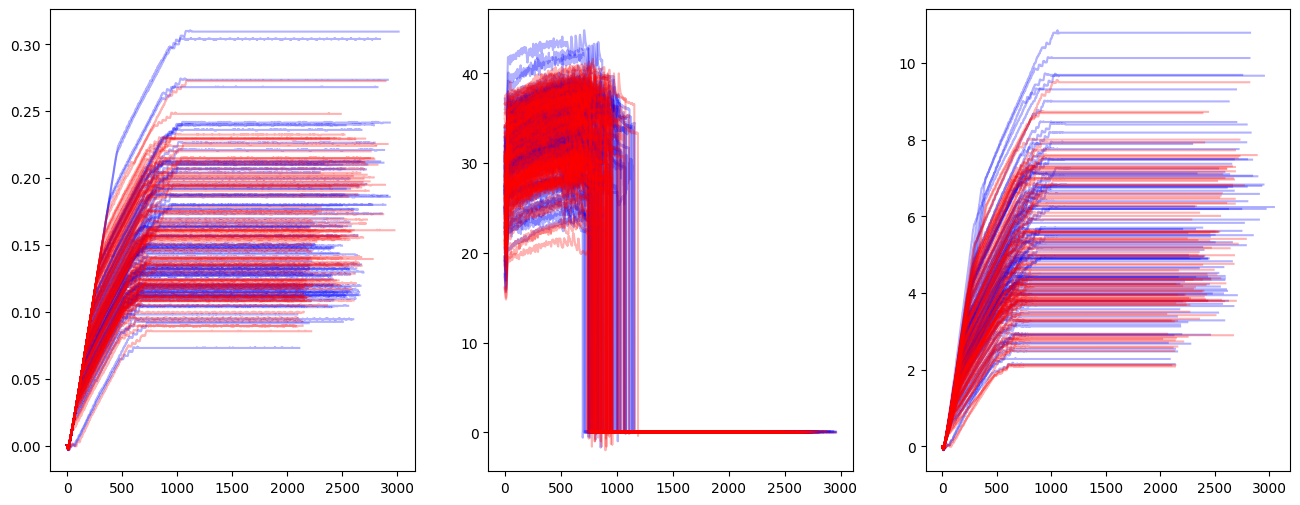

In [260]:
%matplotlib inline


nsample = 100

plt.figure(figsize=[16,6])
plt.subplot(131)
# plt.xlim([-10,1500])
for f in ok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    plt.plot(df_curve.WegSpd1, color='blue', alpha=0.3)


for f in nok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    plt.plot(df_curve.WegSpd1, color='red', alpha=0.3)
    
    
fig = plt.subplot(132)
# plt.xlim([-10,1500])
for f in ok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    plt.plot(df_curve.KraftSpd1, color='blue', alpha=0.3)


for f in nok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    plt.plot(df_curve.KraftSpd1, color='red', alpha=0.3)
    
fig = plt.subplot(133)
# plt.xlim([-10,1500])
for f in ok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    plt.plot(df_curve.energy, color='blue', alpha=0.3)


for f in nok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    plt.plot(df_curve.energy, color='red', alpha=0.3)
    

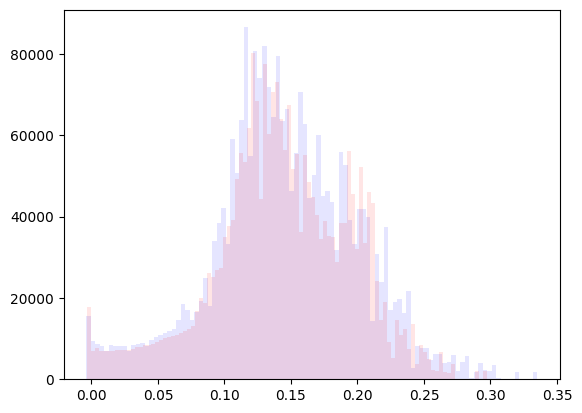

In [261]:
_ = plt.hist(df_ok.WegSpd1, bins=100, color='blue', alpha=0.1)
_ = plt.hist(df_nok.WegSpd1, bins=100, color='red', alpha=0.1)

### distance - force, nothing

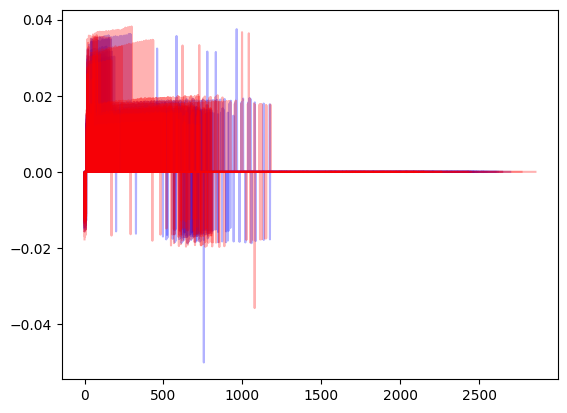

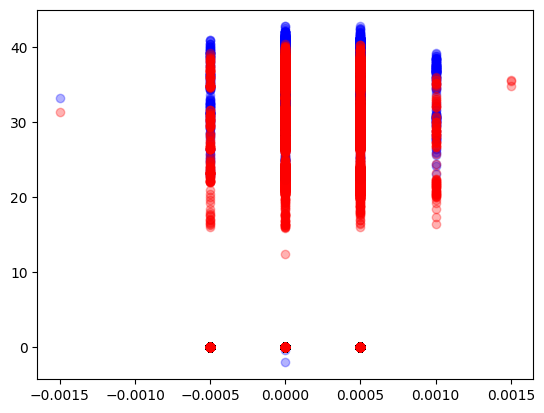

In [152]:

nsample=10

d=1


for f in ok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    plt.plot((df_curve.WegSpd1[d:].values - df_curve.WegSpd1[:-d].values) * df_curve.KraftSpd1[:-d].values, color='blue', alpha=0.3)


for f in nok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    plt.plot((df_curve.WegSpd1[d:].values - df_curve.WegSpd1[:-d].values) * df_curve.KraftSpd1[:-d].values, color='red', alpha=0.3)
    

plt.figure()
    
for f in ok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    plt.scatter(df_curve.WegSpd1[1:].values - df_curve.WegSpd1[:-1].values, df_curve.KraftSpd1[:-1], color='blue', alpha=0.3)


for f in nok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    plt.scatter(df_curve.WegSpd1[1:].values - df_curve.WegSpd1[:-1].values, df_curve.KraftSpd1[:-1],  color='red', alpha=0.3)
    
    
    

### distance to sharpness

## statistics of sharpness

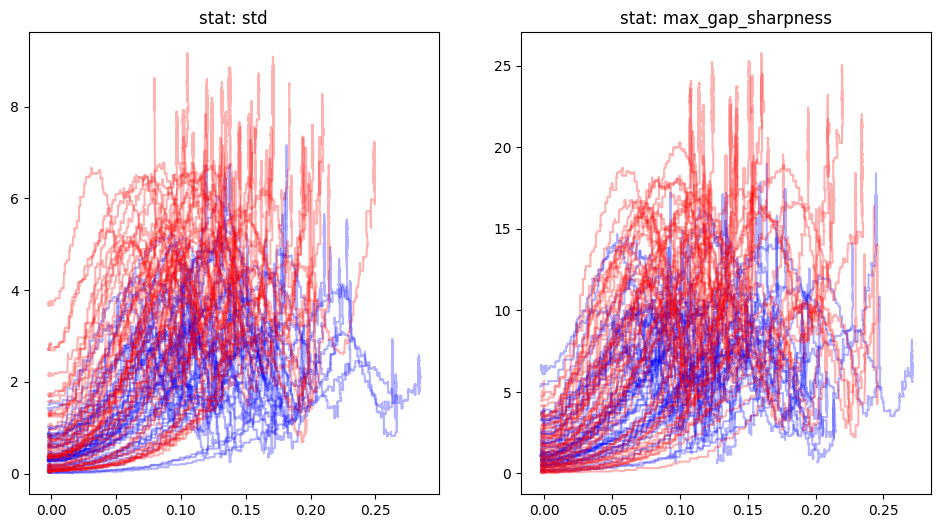

In [262]:
sharpness_keys = ['K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC']
nsample = 50
def max_gap_sharpness(df_curve):
    return df_curve['WegSpd1'].values,[i.max() - i.min() for i in df_curve[sharpness_keys].values]

def max_gap_window_sharpness(df_curve, window = 100):
    c = np.array( [i.max() - i.min() for i in df_curve[sharpness_keys].values] )
    return [np.max(c[i:i+window]) - np.min(c[i:i+window]) for i in np.arange(len(c) - window)] 
#     return [c[i+window] - c[i] for i in np.arange(len(c) - window)] 

def std_sharpness(df_curve):
    return df_curve['WegSpd1'].values, [i.std() for i in df_curve[sharpness_keys].values]
 

_x = df_curve['WegSpd1']

plt.figure(figsize=[18,6])
plt.subplot(131)    
plt.title('stat: std')
for f in ok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    x,y = std_sharpness(df_curve)
    plt.plot(x,y, color='blue', alpha=0.3)


for f in nok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    x,y = std_sharpness(df_curve)
    plt.plot(x,y, color='red', alpha=0.3)
    
    
plt.subplot(132)    
plt.title('stat: max_gap_sharpness')
for f in ok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    x,y = max_gap_sharpness(df_curve)
    plt.plot(x, y, color='blue', alpha=0.3)


for f in nok_files.sample(nsample).values:
    df_curve = parse_curve(f)
    x,y = max_gap_sharpness(df_curve)
    plt.plot(x, y, color='red', alpha=0.3)

    
# plt.subplot(133)    
# plt.title('stat: max_gap_window_sharpness')
# for f in ok_files.sample(nsample).values:
#     df_curve = parse_curve(f)
#     plt.plot(max_gap_window_sharpness(df_curve), color='blue', alpha=0.1)


# for f in nok_files.sample(nsample).values:
#     df_curve = parse_curve(f)
#     plt.plot(max_gap_window_sharpness(df_curve), color='red', alpha=0.1)


# classification

In [16]:
df_feature_all.columns

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29, 'label'],
      dtype='object')

In [19]:
feature_columns = np.arange(30)
x = df_feature_all[feature_columns].values
y = df_feature_all['label'].values

In [20]:
modelcount = 100
levels = 10
model = xgb.XGBClassifier(max_depth= levels, learning_rate=0.1, n_estimators=modelcount,
                              silent=True, objective='binary:logistic', booster='gbtree')
model.fit(x, y)

[21:41:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [22]:
# load for test
feature_ok, feature_nok = [], []
for f in ok_files.sample(500).values:
    pf = parse_curve(os.path.join(curve_path, f))     
    feature_ok.append( get_feature(pf) )
    
for f in nok_files.sample(100).values:
    pf = parse_curve(os.path.join(curve_path, f))                   
    feature_nok.append( get_feature(pf) )
 
df_test_ok = pd.DataFrame(feature_ok)
df_test_nok = pd.DataFrame(feature_nok)
# df_feature_ok['label'] = 1
# df_feature_nok['label'] = 0
# df_feature_all = df_feature_ok.append(df_feature_nok)



In [23]:
pred_ok = model.predict(df_test_ok[feature_columns].values)
pred_nok = model.predict(df_test_nok[feature_columns].values)

FN, TP = len(pred_ok[pred_ok == 0]), len(pred_ok[pred_ok == 1])
TN, FP = len(pred_nok[pred_nok == 0]), len(pred_nok[pred_nok == 1])

FN, TP, TN, FP

(8, 492, 42, 58)

In [352]:
error = (TP * 0.42 - FP)/(FN+TP+TN+FP)
error

0.31193333333333334

In [25]:
FP, TP = len(pred_nok[pred_nok == 1]), len(pred_nok[pred_nok == 0])
error = (TP * 0.42 - FP)/(FN+TP+TN+FP)
print(error)

-0.2690666666666667


In [26]:
FP, TP = len(pred_ok[pred_ok == 0]), len(pred_nok[pred_nok == 0])
error = (TP * 0.42 - FP)/(FN+TP+TN+FP)
print(error,TP,FP)

0.0964 42 8


## inference

In [28]:
# load for test
df_infer = pd.read_csv('sample_submission.csv')
files = df_infer.FilePath
inf_feature = []

for f in files.values:
    pf = parse_curve(os.path.join(curve_path, f))     
    inf_feature.append( get_feature(pf) )
     
df_inf = pd.DataFrame(inf_feature)
# df_feature_ok['label'] = 1
# df_feature_nok['label'] = 0
# df_feature_all = df_feature_ok.append(df_feature_nok)

pred = model.predict(df_inf[feature_columns].values)
result = []
for i in range(len(pred)):
    if pred[i] == 0:
        result.append('NOK')
    else:
        result.append('OK')
#path_name = df_test['FilePath']
cont_list = {'FilePath':files.values, 'Decision':result}
df = pd.DataFrame(cont_list, columns=['FilePath','Decision'])
df.to_csv('yun.csv')

NameError: name 'predict' is not defined

In [29]:
pred = model.predict(df_inf[feature_columns].values)

In [30]:
result = []
for i in range(len(pred)):
    if pred[i] == 0:
        result.append('NOK')
    else:
        result.append('OK')

In [31]:
#path_name = df_test['FilePath']
cont_list = {'FilePath':files.values, 'Decision':result}
df = pd.DataFrame(cont_list, columns=['FilePath','Decision'])
df.to_csv('yun.csv')